In [1]:
from LSTM import LSTM
import torch
import numpy as np 
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable


In [2]:
################
#  DATALOADING #
################

In [3]:

def sliding_windows(data,seq_length):
    x = []
    y = []

    for i in range(data.shape[1]-seq_length-1):
        _x = data[:,i:(i+seq_length)]
        _y = data[:,i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)





In [7]:

data = np.load('midprices-new.npy')
#Reshaping data and seperating training and test set
sc = MinMaxScaler()
data = sc.fit_transform(data.reshape(-1,1))
data = data.reshape((1,data.shape[0]))
seq_length = 4
x, y = sliding_windows(data, seq_length)

bsz = 64
size = y.shape[0]
train_size = int(size * 0.67)
test_size = size - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))


trainX = dataX[0:train_size,:,:]
trainY = dataY[0:train_size,:]


testX = dataX[train_size:size, :,:]
testY = dataY[train_size:size,:]

trainingset =[]
for i in range(len(trainY)):
    trainingset.append((trainX[i,:,:], trainY[i,:]))


trainloader = torch.utils.data.DataLoader(trainingset, batch_size=bsz, shuffle=False)


In [8]:
num_epochs = 2000
learning_rate = 1e-3

input_size = 4
hidden_size = 256
num_layers = 1
seq_length = 4
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length, fc1_out = 128)
lstm.load_state_dict(torch.load('../Models/midprice-regression-new', map_location='cpu'))


<All keys matched successfully>

In [ ]:
trainX = trainX.unsqueeze(1)
test_hist = []
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    total_loss = 0
    j = 0  
    for i, (inputs, targets) in enumerate(trainloader):
        outputs = lstm(inputs.to(device))

        optimizer.zero_grad()
    # obtain the loss function
        loss = criterion(outputs, targets.to(device))
    
        loss.backward()
    
        optimizer.step()
        
        total_loss += loss.item()
        j +=1
    if testX is not None:
        with torch.no_grad():
            y_test_pred = lstm(testX.to(device))
            test_loss = criterion(y_test_pred.float(), testY.to(device))
            test_hist.append( test_loss.item())
    total_loss /=j
    if epoch % 2 == 0:
        print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, total_loss, test_hist[epoch]))
        torch.save(lstm.state_dict(), f'../Models/midprice-regression-new')

/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([401608])) that is different to the input size (torch.Size([401608, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Before
After


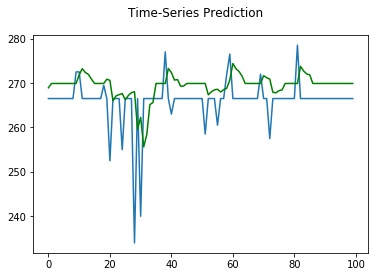

In [11]:
import matplotlib.pyplot as plt

lstm.eval()
print("Before")
size = train_size+test_size
train_predict = lstm(dataX[size-100:size])
print("After")
data_predict = train_predict.data.numpy()[0:100]
dataY_plot = dataY.data.numpy()[size-100:size]
data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict, c='green')
plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
torch.save(lstm.state_dict(), '../Models/state2-regression')

In [13]:
import pickle
with open('sc_midprice', 'wb') as f:
    pickle.dump(sc, f)
    